Using the equations of motion and the trivial derivative equations:

theta defined as the rotation along the positive y direction

$
\begin{aligned}
& F_x = \dot{v_x}m = (u_1 + u_2 + u_3) \sin(\theta)\\
& F_z = \dot{v_z}m = (u_1 + u_2 + u_3)\cos (\theta) - mg\\
& M_y = (u_3-u_1)L_{ca}\\
& \\
& \dot p_x = v_x\\
& \dot p_z = v_z\\
& \dot \theta = q
\end{aligned}
$

Rearranging gives the following state space equations:

$
x = 
\begin{bmatrix}
p_x\\
p_z\\
\theta\\
v_x\\
v_z\\
q
\end{bmatrix}
$

$
\dot x = 
\begin{bmatrix}
v_x\\
v_z\\
q\\
\frac{(u_1 + u_2 + u_3)\sin(\theta)}{m}\\
\frac{(u_1 + u_2 + u_3)\cos \theta}{m} - g\\
\frac{(u_3-u_1)L_{ca}}{I}
\end{bmatrix}
$

Let's try to implement this in rockit

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      788
Number of nonzeros in inequality constraint Jacobian.:       63
Number of nonzeros in Lagrangian Hessian.............:      280

Total number of variables............................:      186
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      128
Total number of inequality constraints...............:       63
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       63
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.0000000e+01 1.00e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

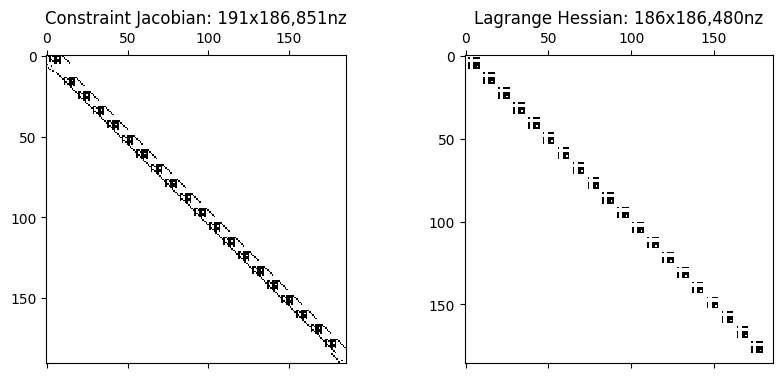

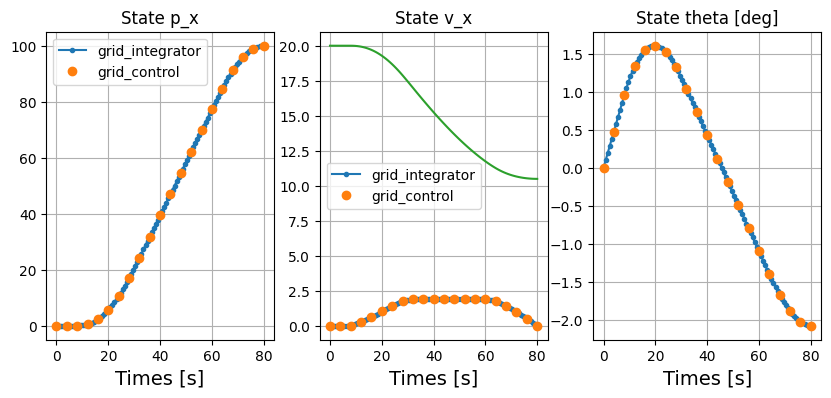

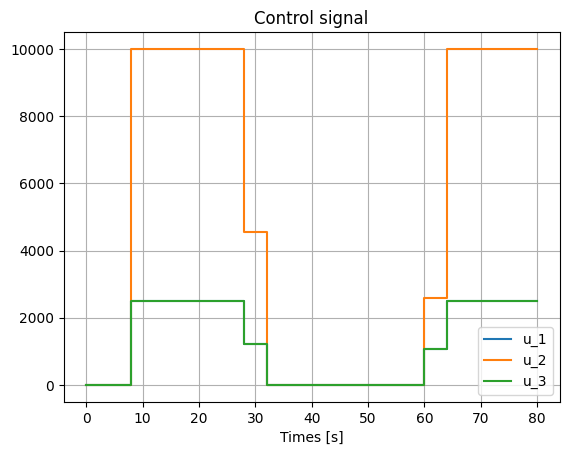

In [ ]:
from rockit import *
from numpy import sin, pi
import matplotlib.pyplot as plt
import numpy as np

ocp = Ocp(T=20.0)

# Define constants
g = 1.625 # m/s^2
m = 4280.0 # kg
L_ca = 2.11 # m
I = 1000 # kg*m^2
F_max_1 = 2500 # N
F_max_2 = 10000 # N (center one is stronger)
F_max_3 = 2500 # N

# Fuel consumption is ~ force², center engine is twice as efficient
consumption_coeff_1 = 1.0
consumption_coeff_2 = 0.5
consumption_coeff_3 = 1.0


# define states
p_x = ocp.state()   # position x
p_z = ocp.state()   # position z
theta = ocp.state() # angle
v_x = ocp.state()   # velocity x
v_z = ocp.state()   # velocity z
q = ocp.state()     # angular velocity

# define controls
u_1 = ocp.control() # thrust engine 1
u_2 = ocp.control() # thrust engine 2
u_3 = ocp.control() # thrust engine 3

# define ODEs
ocp.set_der(p_x, v_x)
ocp.set_der(p_z, v_z)
ocp.set_der(theta, q)
ocp.set_der(v_x, (u_1 + u_2 + u_3) * np.sin(theta) / m)
ocp.set_der(v_z, (u_1 + u_2 + u_3) * np.cos(theta) / m - g)
ocp.set_der(q, (L_ca * (u_3 - u_1)) / I)

# Lagrange objective
ocp.add_objective(ocp.T)
# penalty on q angular velocity
ocp.add_objective(ocp.integral(q**2))
#ocp.add_objective(ocp.integral(p_z**2))

# Path constraints
ocp.subject_to(0 <= (u_1 <= F_max_1))
ocp.subject_to(0 <= (u_2 <= F_max_2))
ocp.subject_to(0 <= (u_3 <= F_max_3))


# Initial constraints
ocp.subject_to(ocp.at_t0(p_x)==0)
ocp.subject_to(ocp.at_t0(v_x)==0)
ocp.subject_to(ocp.at_t0(p_z)==0)
ocp.subject_to(ocp.at_t0(theta)==0)
ocp.subject_to(ocp.at_t0(v_z)==0)


# End constraints
d = 100.0
ocp.subject_to(ocp.at_tf(p_x)==d)
ocp.subject_to(ocp.at_tf(v_x)==0)
ocp.subject_to(ocp.at_tf(p_z)==0)


# Pick a solver for the discretized NLP
ocp.solver('ipopt')

# Choose a solution method to transcribe the OCP into an NLP (discretization)
ocp.method(MultipleShooting(N=20, M=1, intg='rk'))

# Visualize the OCP
ocp.spy()

# solve
sol = ocp.solve()

from pylab import *

# Post-processing
tsa, pa_x = sol.sample(p_x, grid='control')
tsa, va_x = sol.sample(v_x, grid='control')
# for z direction
tsa, pa_z = sol.sample(p_z, grid='control')
tsa, va_z = sol.sample(v_z, grid='control')
# for theta
tsa, theta_a = sol.sample(theta, grid='control')
tsa, q_a = sol.sample(q, grid='control')

tsb, pb_x = sol.sample(p_x, grid='integrator', refine=5)
tsb, vb_x = sol.sample(v_x, grid='integrator', refine=5)
# for z direction
tsb, pb_z = sol.sample(p_z, grid='integrator', refine=5)
tsb, vb_z = sol.sample(v_z, grid='integrator', refine=5)
# for theta
tsb, theta_b = sol.sample(theta, grid='integrator', refine=5)
tsb, q_b = sol.sample(q, grid='integrator', refine=5)



figure(figsize=(10, 4))
subplot(1, 3, 1)
plot(tsb, pb_x, '.-')
plot(tsa, pa_x, 'o')
xlabel("Times [s]", fontsize=14)
legend(['grid_integrator', 'grid_control'])
grid(True)
title('State p_x')

subplot(1, 3, 2)
plot(tsb, vb_x, '.-')
plot(tsa, va_x, 'o')
plot(tsb, 20 - 10*sin(pi*pb_x/250))
legend(['grid_integrator', 'grid_control'])
xlabel("Times [s]", fontsize=14)
title('State v_x')
grid(True)

subplot(1, 3, 3)
plot(tsb, np.rad2deg(theta_b), '.-')
plot(tsa, np.rad2deg(theta_a), 'o')
xlabel("Times [s]", fontsize=14)
title('State theta [deg]')
grid(True)

tsol, usol_1 = sol.sample(u_1, grid='control')
tsol, usol_2 = sol.sample(u_2, grid='control')
tsol, usol_3 = sol.sample(u_3, grid='control')

figure()
step(tsol,usol_1,where='post')
step(tsol,usol_2,where='post')
step(tsol,usol_3,where='post')
title("Control signal")
xlabel("Times [s]")
legend(['u_1','u_2','u_3'])
grid(True)

plt.show(block=True)

In [76]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Sample controls on the same grid as states for animation
tsb, ub_1 = sol.sample(u_1, grid='integrator', refine=5)
tsb, ub_2 = sol.sample(u_2, grid='integrator', refine=5)
tsb, ub_3 = sol.sample(u_3, grid='integrator', refine=5)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
ax.grid(True)
ax.set_xlabel('X [m]')
ax.set_ylabel('Z [m]')
ax.set_title('Moonlander Animation')

# Set limits based on trajectory
x_min, x_max = np.min(pb_x), np.max(pb_x)
z_min, z_max = np.min(pb_z), np.max(pb_z)
margin = 5
ax.set_xlim(x_min - margin, x_max + margin)
ax.set_ylim(z_min - margin, z_max + margin)

# Elements to animate
lander_body, = ax.plot([], [], 'k-', linewidth=2)
trajectory, = ax.plot([], [], 'b--', alpha=0.5)
# Thrusters (lines)
thrust_1, = ax.plot([], [], 'r-', linewidth=2)
thrust_2, = ax.plot([], [], 'r-', linewidth=2)
thrust_3, = ax.plot([], [], 'r-', linewidth=2)

time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Lander geometry
w = 4  # width
h = 2  # height
# Define a rectangle centered at 0,0
body_pts = np.array([
    [-w/2, -h/2],
    [w/2, -h/2],
    [w/2, h/2],
    [-w/2, h/2],
    [-w/2, -h/2]
])

# Thruster positions relative to center
try:
    l_dist = L_ca
except NameError:
    l_dist = 2.11

thruster_origins = np.array([
    [-l_dist, -h/2], # u1
    [0, -h/2],       # u2
    [l_dist, -h/2]   # u3
])

# Scaling factor for thrust visualization
max_thrust = max(np.max(ub_1), np.max(ub_2), np.max(ub_3))
scale = 5.0 / max_thrust if max_thrust > 0 else 1.0

def update(frame):
    # Get current state
    x = pb_x[frame]
    z = pb_z[frame]
    th = theta_b[frame]
    t = tsb[frame]
    
    # Rotation matrix
    # Physics: Force ~ [sin(th), cos(th)]. 
    # We want Body Up [0,1] to align with Force.
    # R @ [0,1] = [sin, cos] => R = [[cos, sin], [-sin, cos]]
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, s], [-s, c]])
    
    # Transform body points
    current_body = (R @ body_pts.T).T + np.array([x, z])
    lander_body.set_data(current_body[:, 0], current_body[:, 1])
    
    # Trajectory
    trajectory.set_data(pb_x[:frame+1], pb_z[:frame+1])
    
    # Thrusters
    u = [ub_1[frame], ub_2[frame], ub_3[frame]]
    thrust_lines = [thrust_1, thrust_2, thrust_3]
    
    for i in range(3):
        if u[i] > 1e-3: # Only draw if active
            # Start point (relative)
            p0_rel = thruster_origins[i]
            # End point (relative) - pointing down (negative y in local frame)
            # Length proportional to thrust
            length = u[i] * scale
            p1_rel = p0_rel + np.array([0, -length])
            
            # Transform to global
            p0 = (R @ p0_rel) + np.array([x, z])
            p1 = (R @ p1_rel) + np.array([x, z])
            
            thrust_lines[i].set_data([p0[0], p1[0]], [p0[1], p1[1]])
        else:
            thrust_lines[i].set_data([], [])

    time_text.set_text(f'Time: {t:.2f} s')
    
    return lander_body, trajectory, thrust_1, thrust_2, thrust_3, time_text

# Create animation
dt = tsb[1] - tsb[0] if len(tsb) > 1 else 0.1
interval = dt * 1000 
interval = max(20, min(interval, 200))

ani = FuncAnimation(fig, update, frames=len(tsb), interval=interval, blit=True)

plt.close(fig)
HTML(ani.to_jshtml())